In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.frozen import FrozenEstimator

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) 
sns.set_theme(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')

In [56]:
#load data
cvd_data = pd.read_csv('data/cardio_data.csv', delimiter=';')

In [57]:
print("=== Dataset Info ===")
cvd_data.info()

print("=== Summary Statistics ===")
display(cvd_data.describe())

print("=== Unique Value Counts ===")
display(cvd_data.nunique())

print("=== Head ===")
display(cvd_data.head())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
=== Summary Statistics ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


=== Unique Value Counts ===


id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

=== Head ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [58]:
#make a copy of data
cleaned_cvd_data = pd.DataFrame(cvd_data)

cleaned_cvd_data.age = cleaned_cvd_data.age // 365
cleaned_cvd_data.gender = cleaned_cvd_data.gender.replace({1:0, 2:1})

#convert negative bp to positive
cleaned_cvd_data.ap_hi = cleaned_cvd_data.ap_hi.abs()
cleaned_cvd_data.ap_lo = cleaned_cvd_data.ap_lo.abs()

#swap ap_hi with ap_lo where ap_hi < ap_lo
swap = cleaned_cvd_data["ap_hi"] < cleaned_cvd_data["ap_lo"]
cleaned_cvd_data.loc[swap, ["ap_hi", "ap_lo"]] = (
    cleaned_cvd_data.loc[swap, ["ap_lo", "ap_hi"]].values
)

#create BMI feature
cleaned_cvd_data["height_m"] = cleaned_cvd_data["height"] / 100
cleaned_cvd_data["bmi"] = cleaned_cvd_data["weight"] / (cleaned_cvd_data["height_m"] ** 2)

cleaned_cvd_data.drop(columns=["height_m"], inplace=True)

In [59]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_cols = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

EDA of Continuous Features


/tmp/ipykernel_42148/1545010163.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cleaned_cvd_data, x='age_group', palette='pastel', order=[1,2,3,4,5])


Text(0.5, 1.0, 'Count by Age Group')

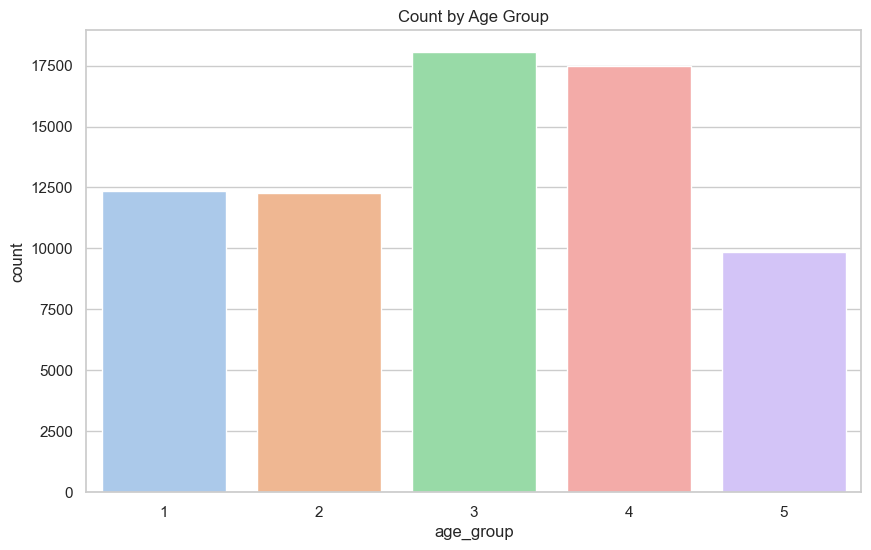

In [60]:
age_group_bin = [0, 45, 50, 55, 60, 65]

cleaned_cvd_data['age_group'] = pd.cut(
    cleaned_cvd_data['age'],
    bins=[0, 45, 50, 55, 60, 65],
    labels=[1,2,3,4,5],
    include_lowest=True
)

sns.countplot(data=cleaned_cvd_data, x='age_group', palette='pastel', order=[1,2,3,4,5])
plt.title('Count by Age Group')

'Histogram of age'

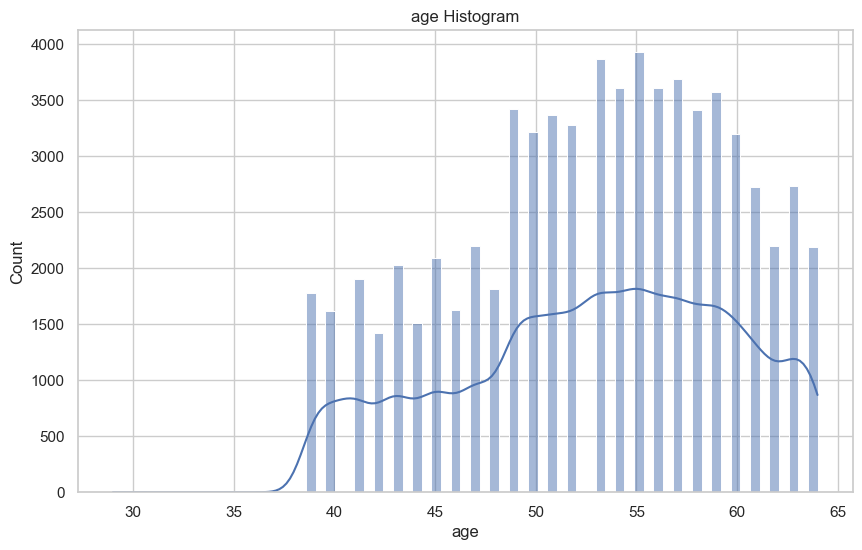

'Histogram of height'

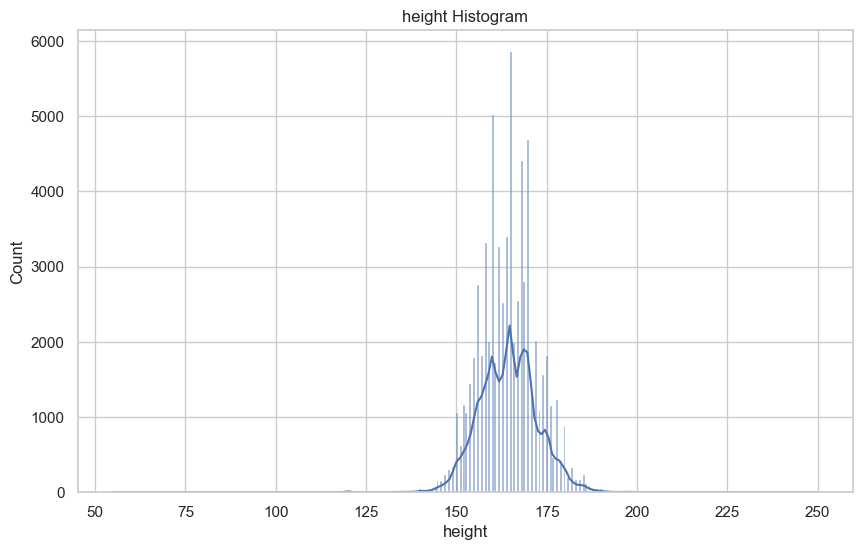

'Histogram of weight'

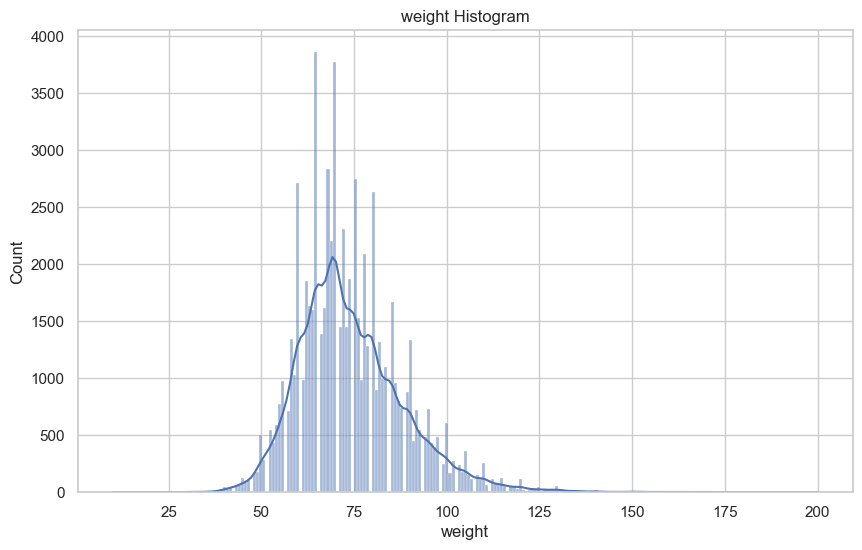

'Histogram of bmi'

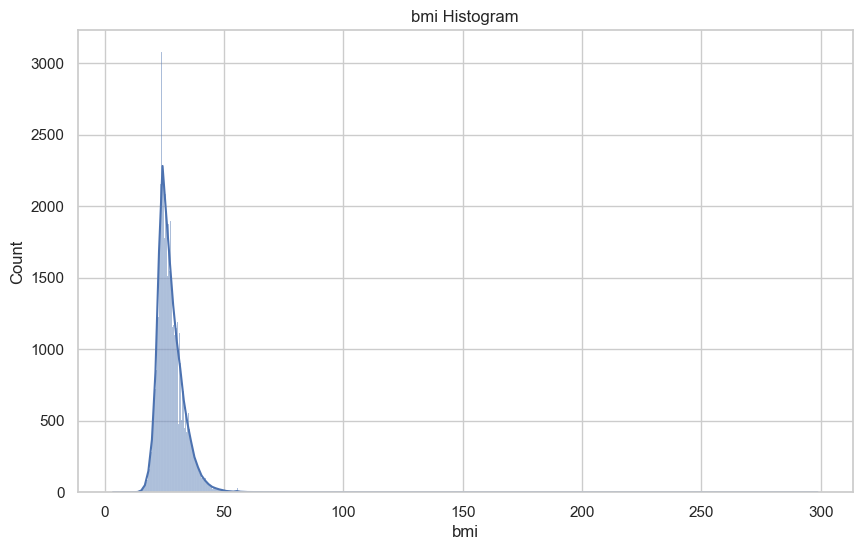

'Histogram of ap_hi'

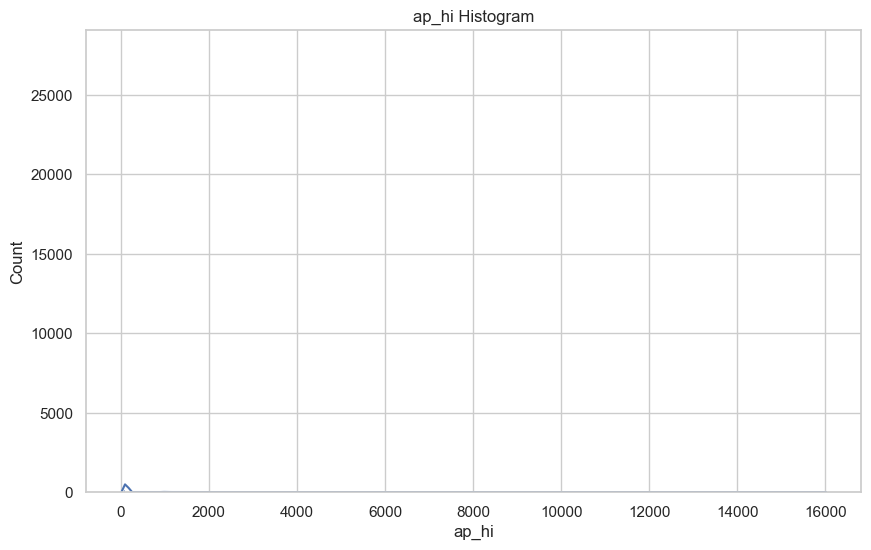

'Histogram of ap_lo'

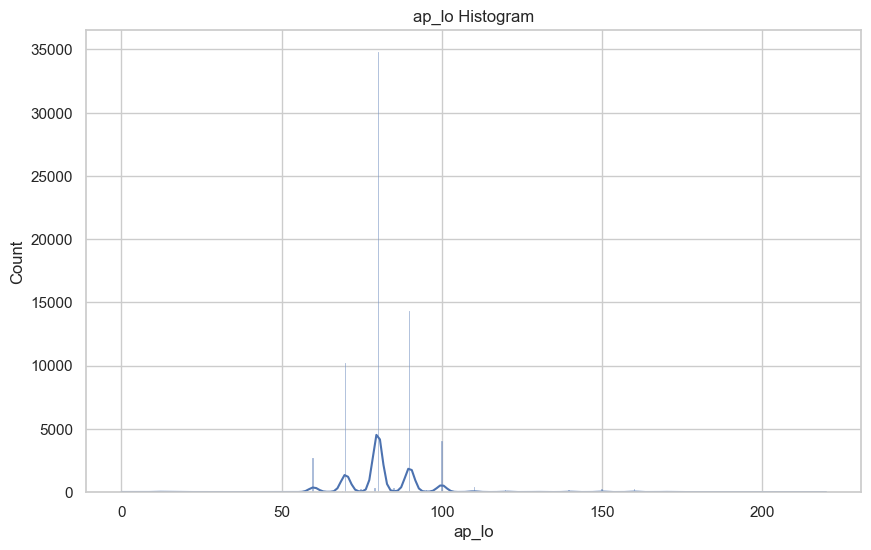

In [61]:
#hist for continuous features
for col in cont_cols:
    display(f"Histogram of {col}")
    sns.histplot(data=cleaned_cvd_data, x = col, kde = True)
    plt.title(f'{col} Histogram')
    plt.show()

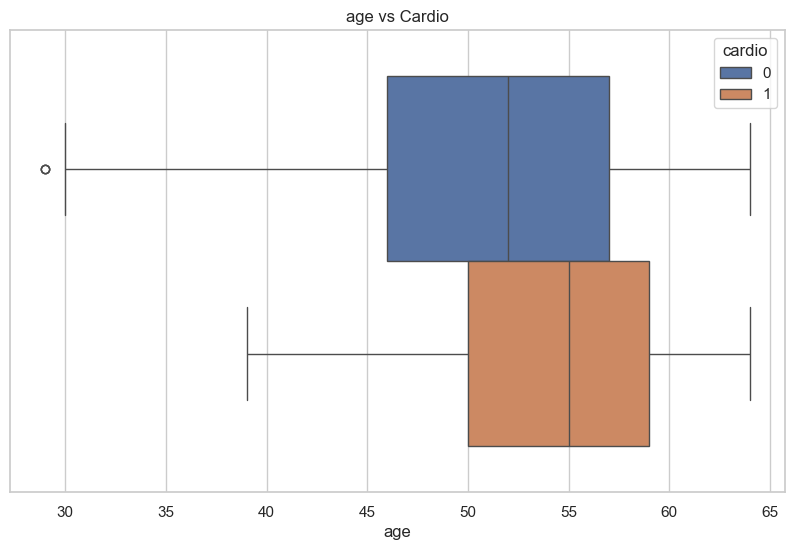

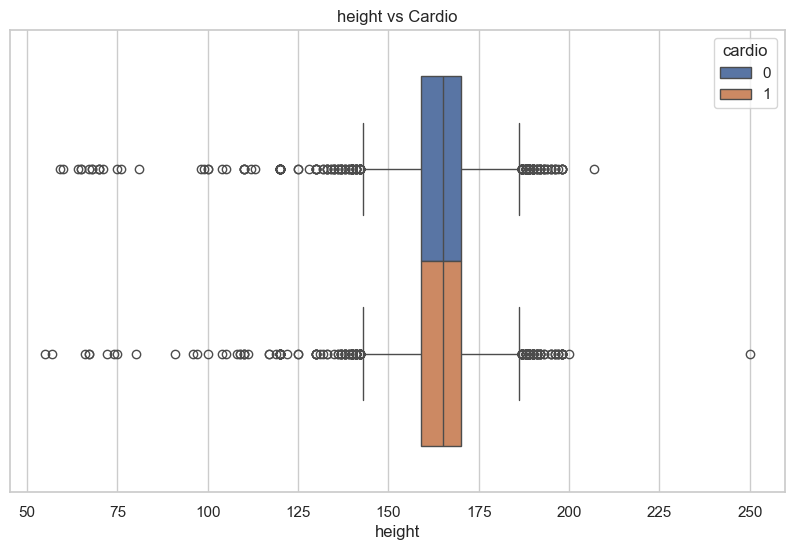

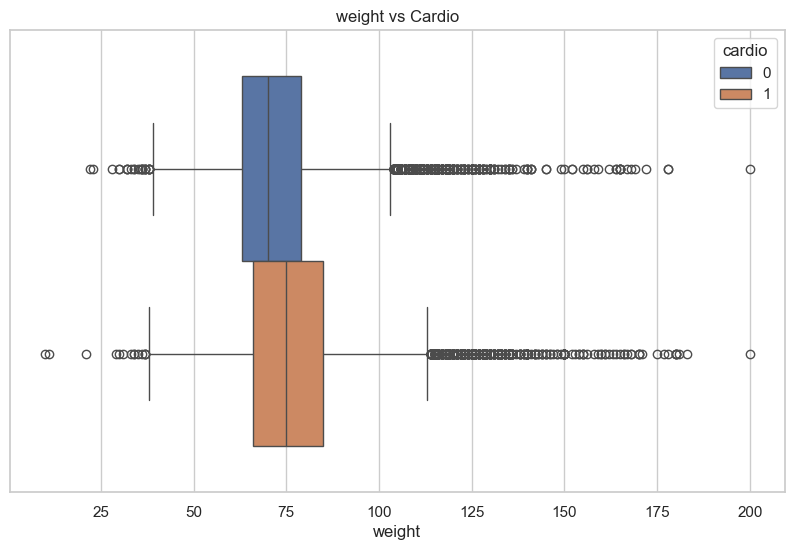

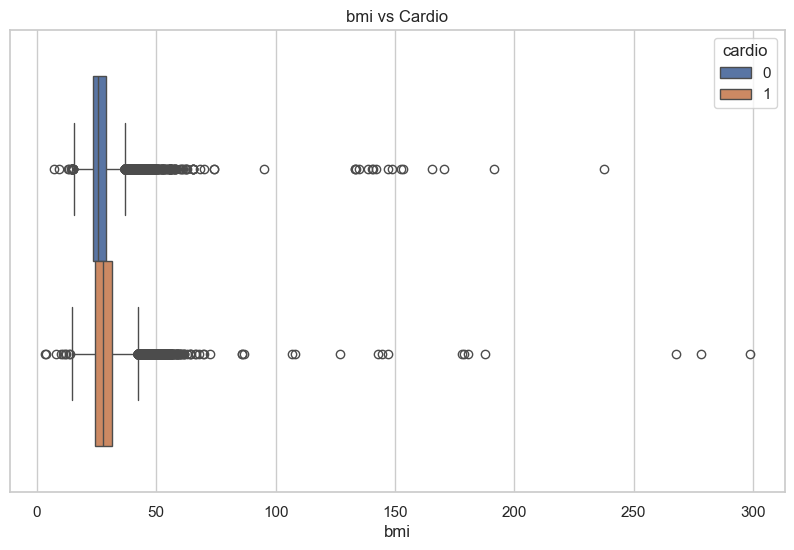

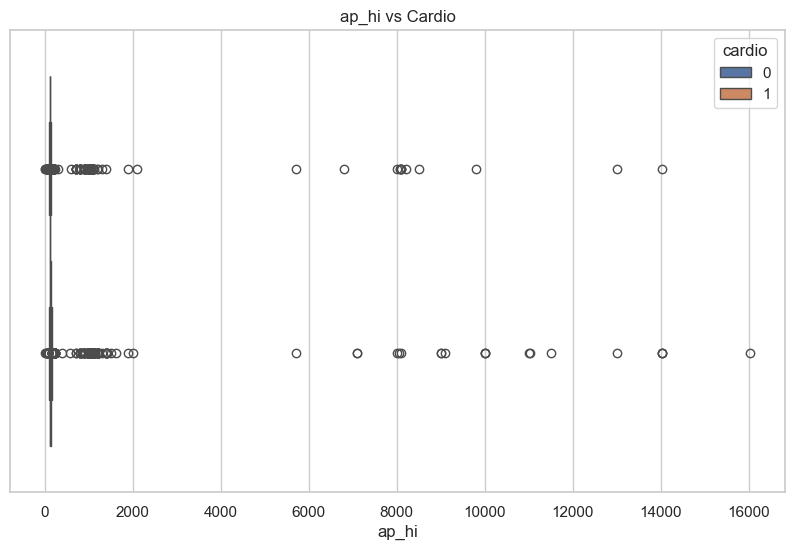

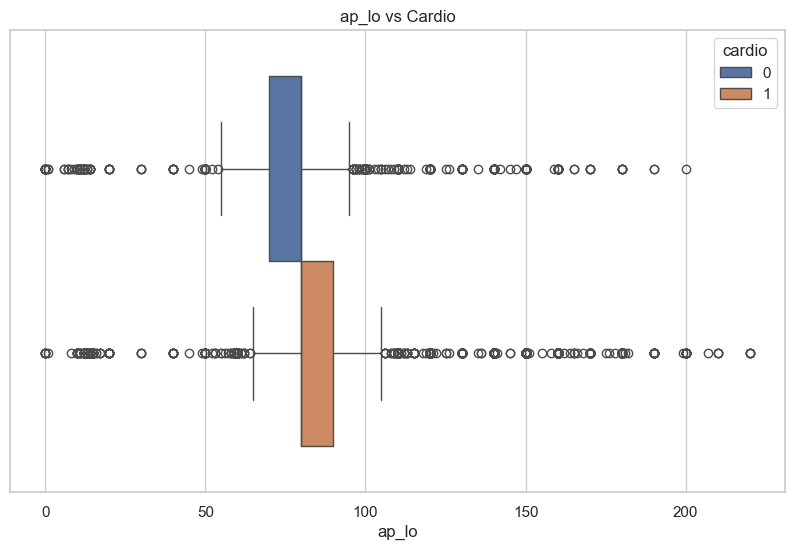

In [62]:
#Boxplot for continuous features
for col in cont_cols:
    sns.boxplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

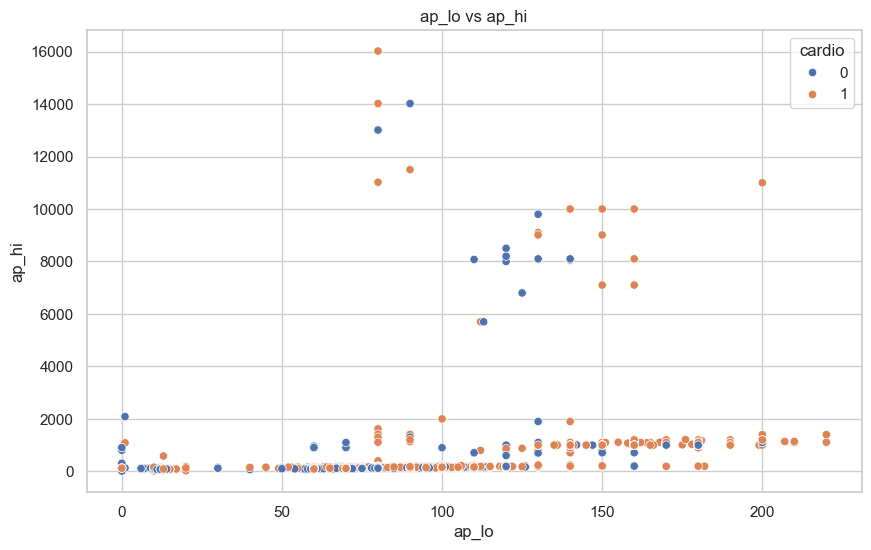

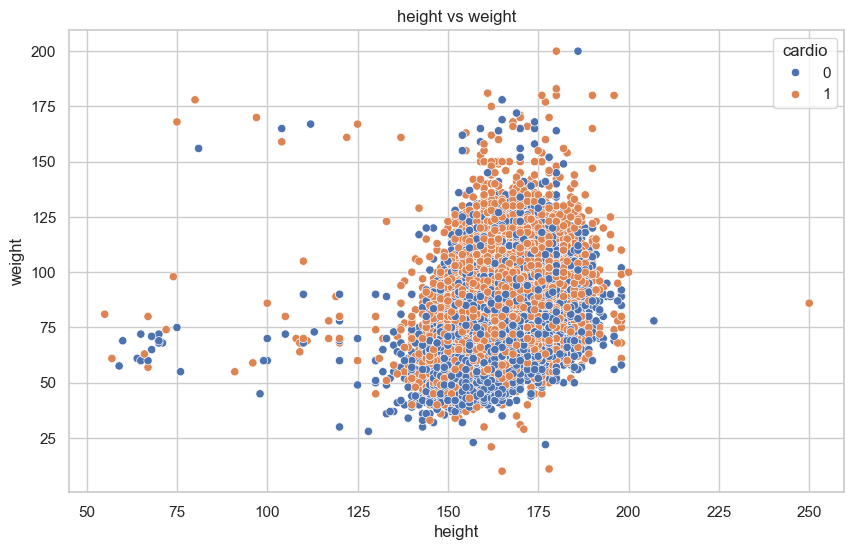

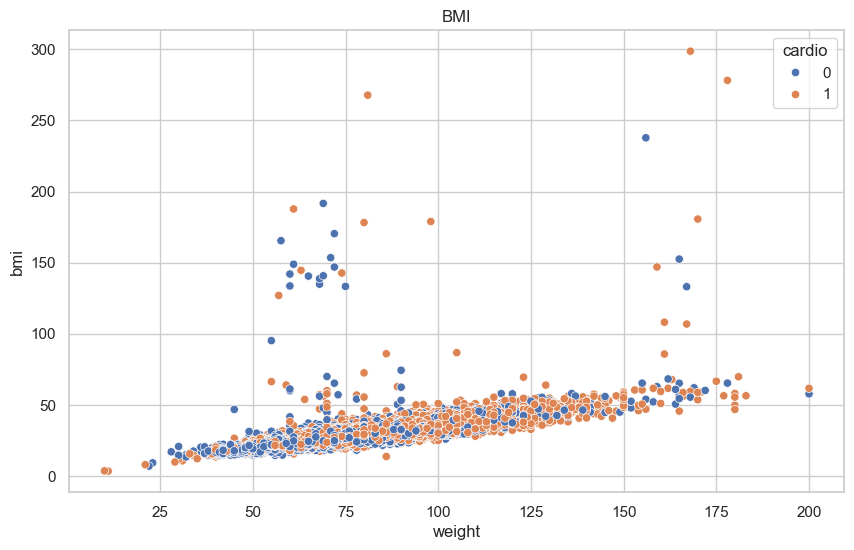

In [63]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x='height', y='weight', hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.title('BMI')
plt.show()

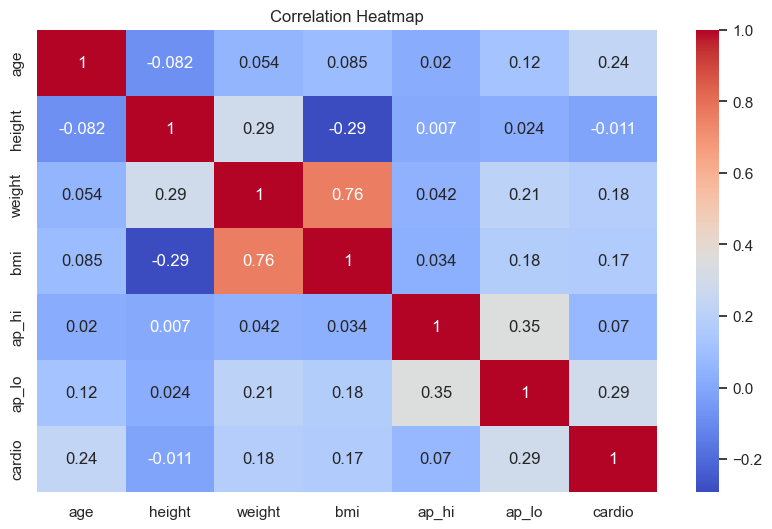

In [64]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Observation**:
ap_hi, ap_lo, weight and height has outlier and contains unrealistic data.

Medically, 70 > ap_hi > 240 is unrealistic,


In [65]:
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_hi <= 240) & (cleaned_cvd_data.ap_hi >= 70)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_lo <= 200) & (cleaned_cvd_data.ap_lo >= 40)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.bmi <= 60) & (cleaned_cvd_data.bmi >= 10)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.height < 200) & (cleaned_cvd_data.height > 120)]

display(cleaned_cvd_data.shape)

(68671, 15)

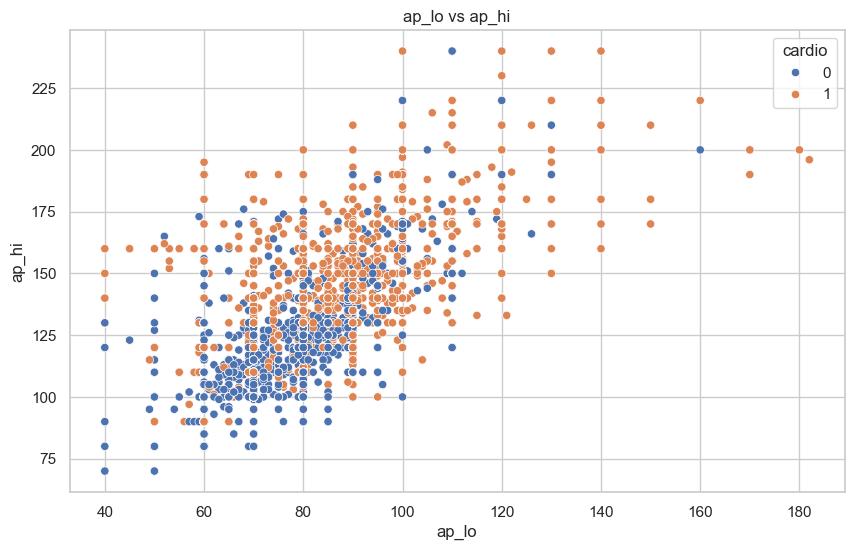

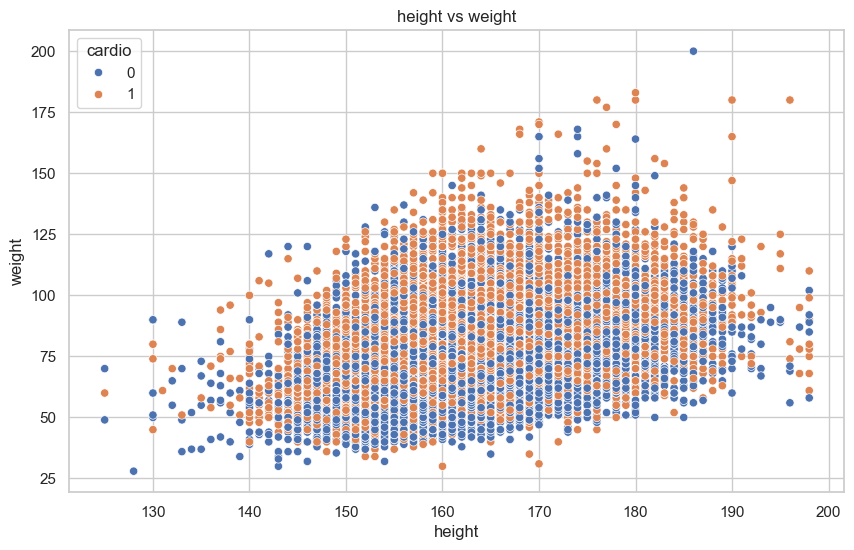

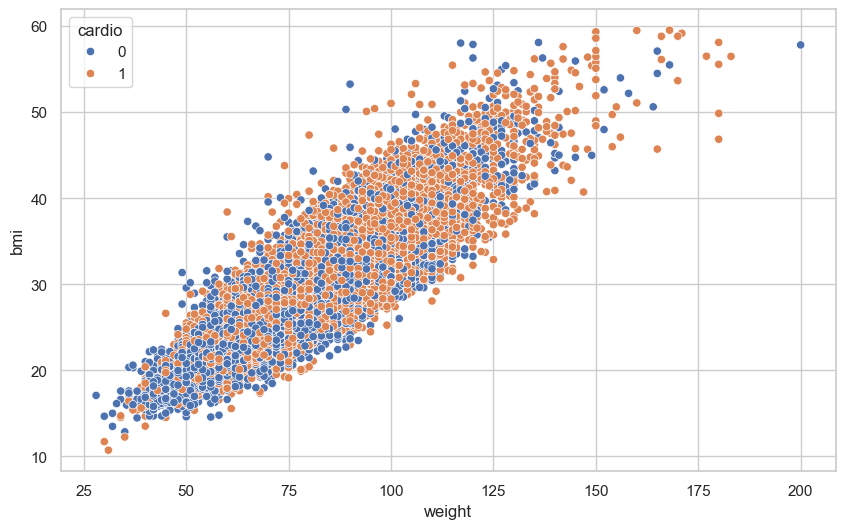

In [66]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x="height", y="weight", hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.show()

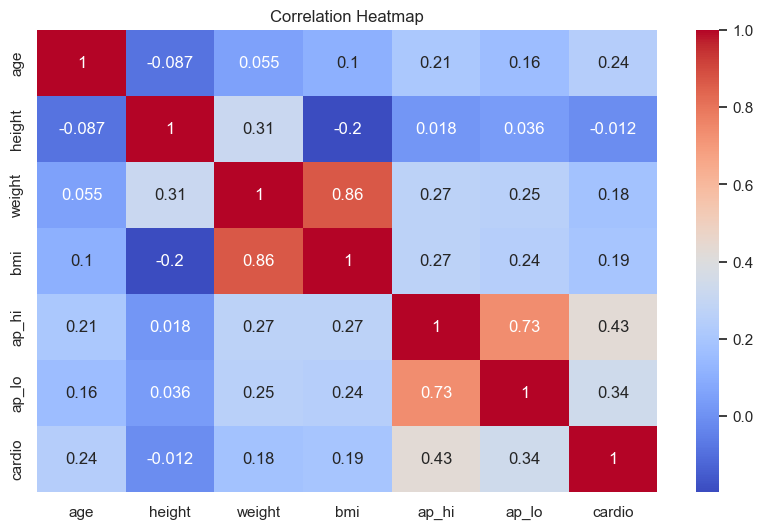

In [67]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Categorical Feature EDA


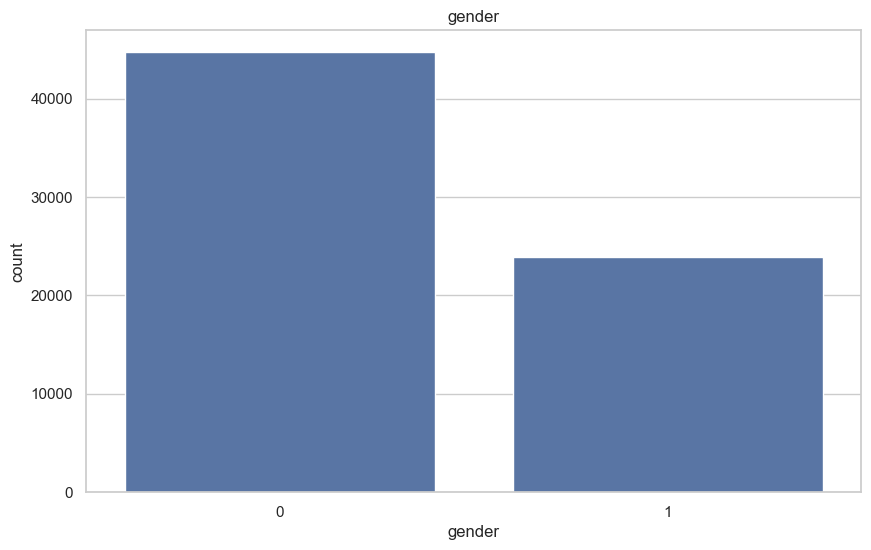

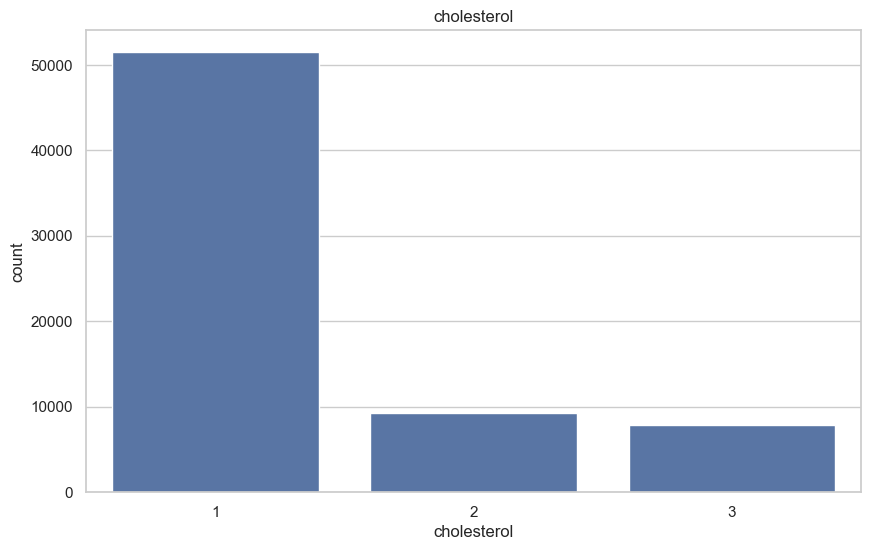

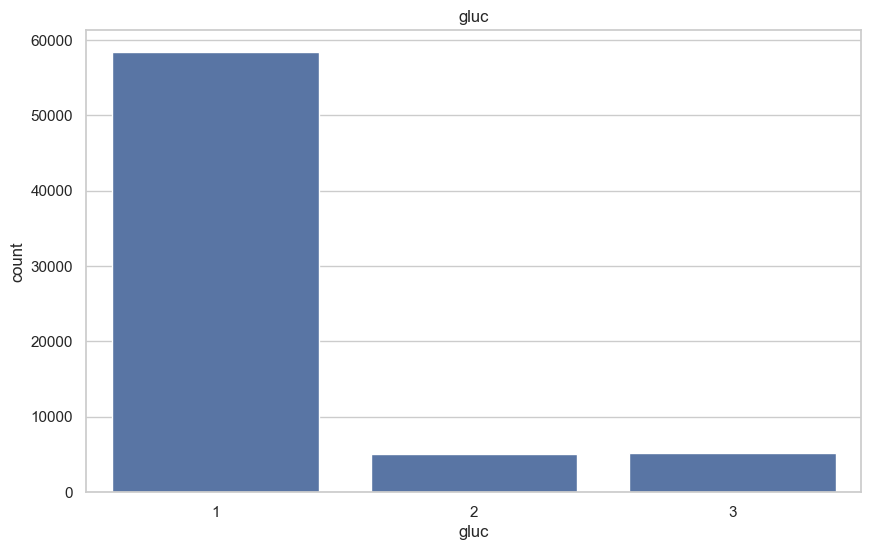

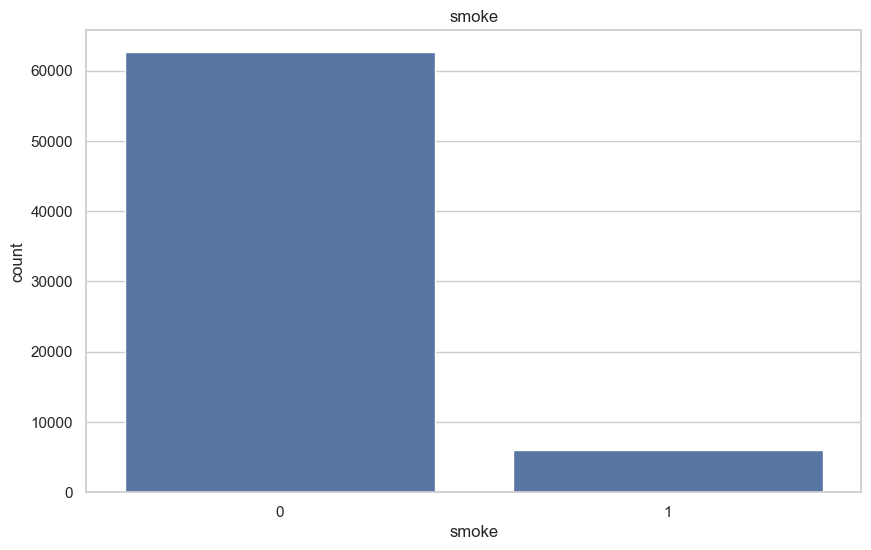

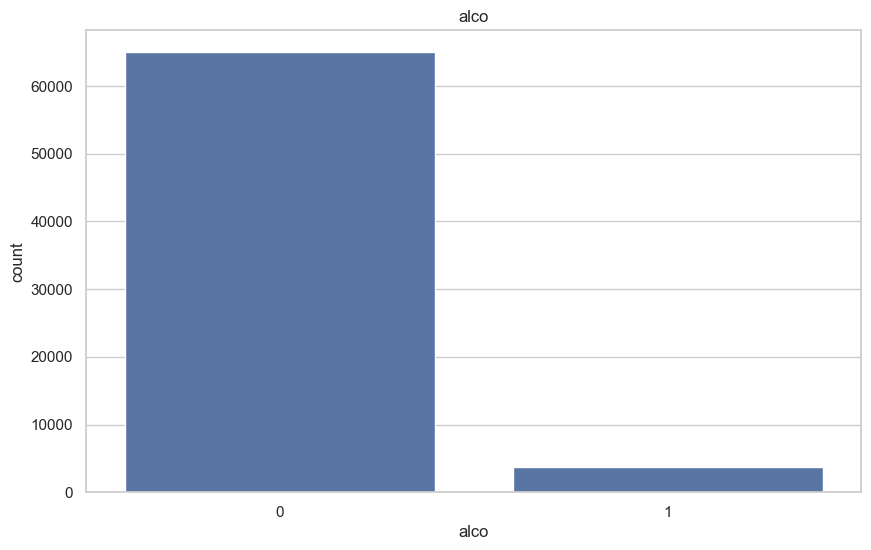

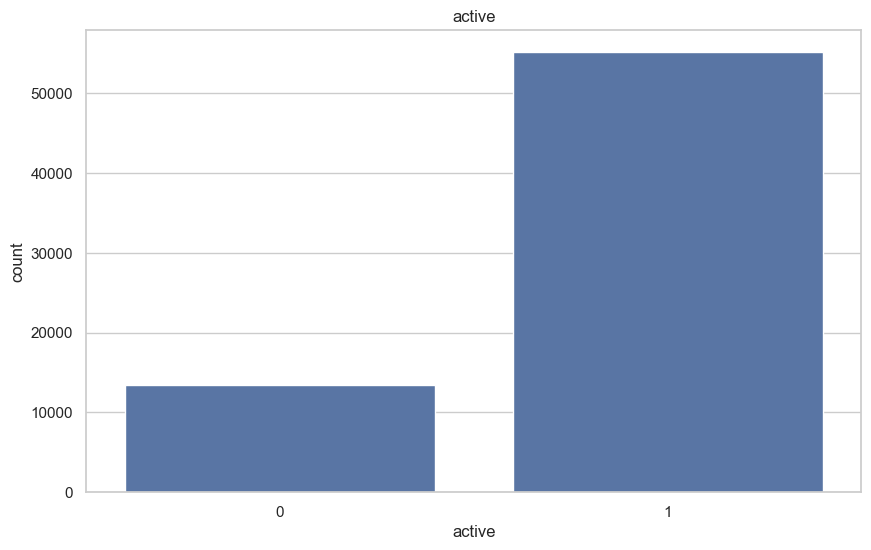

In [68]:
#Countplot of categorical features
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col)
    plt.title(f"{col}")
    plt.show()

Bivariate EDA


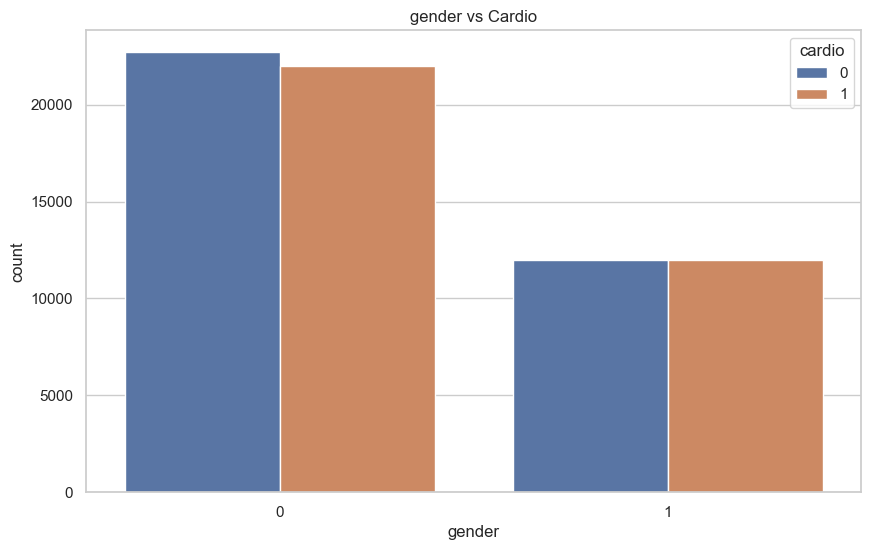

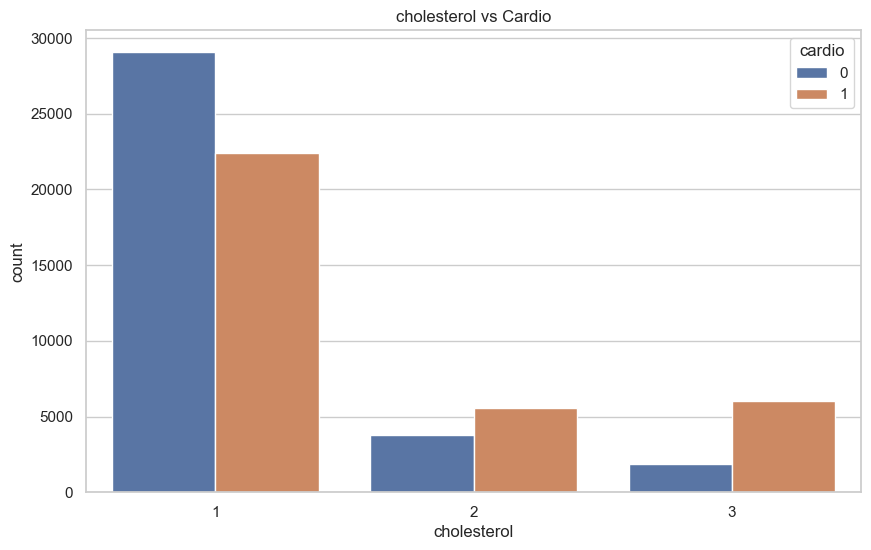

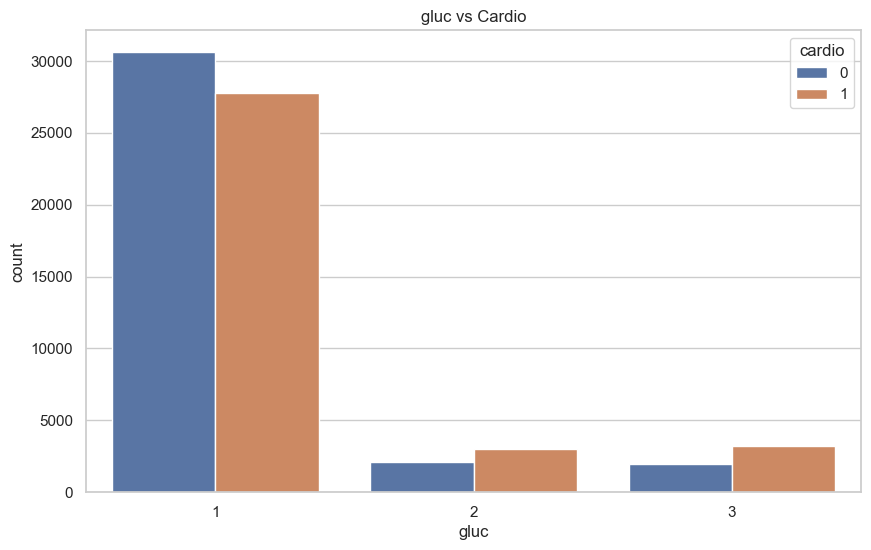

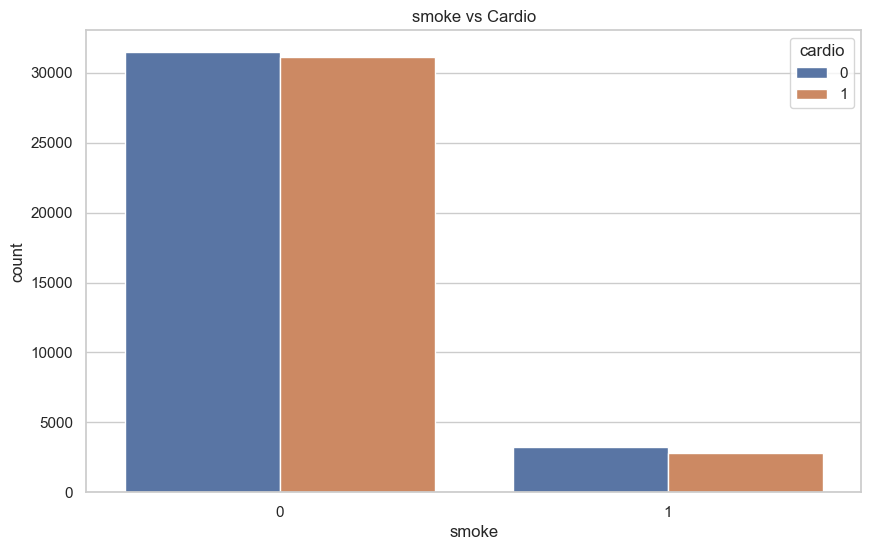

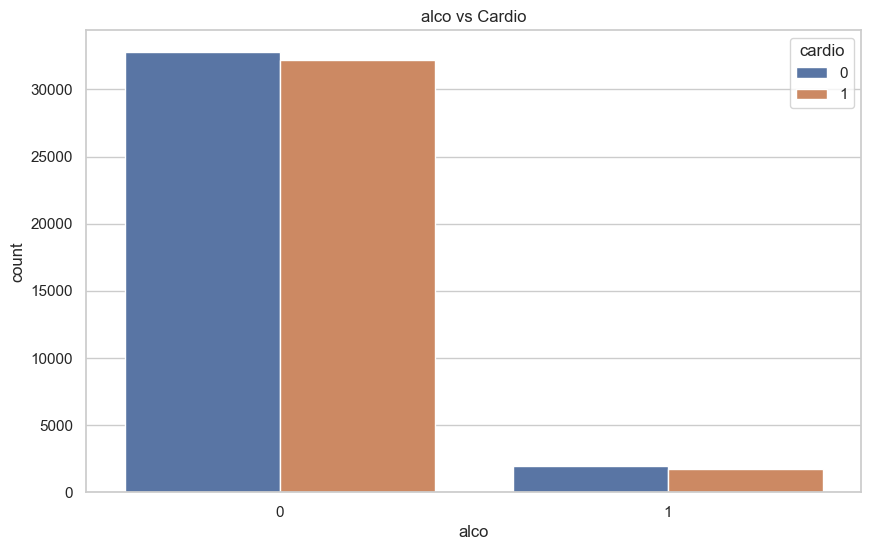

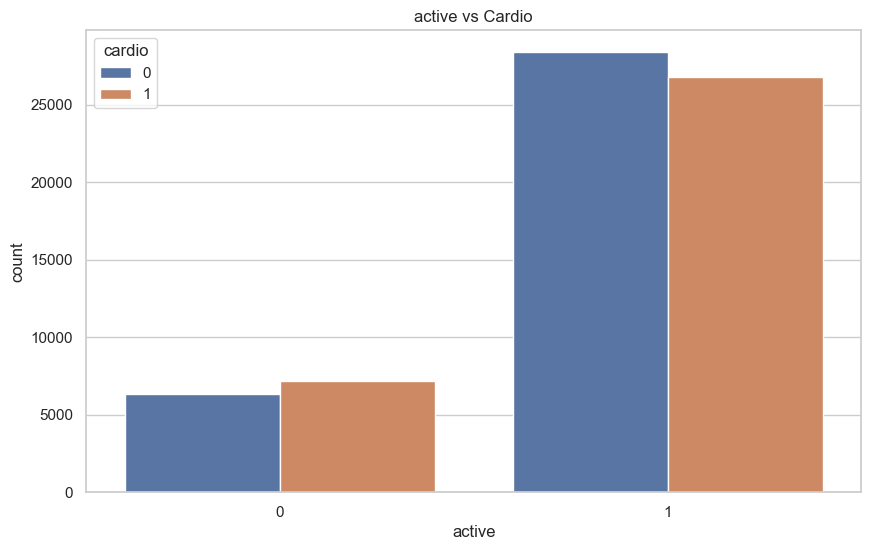

In [69]:
#relation between categorical features and cardio
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

<Axes: xlabel='cardio', ylabel='count'>

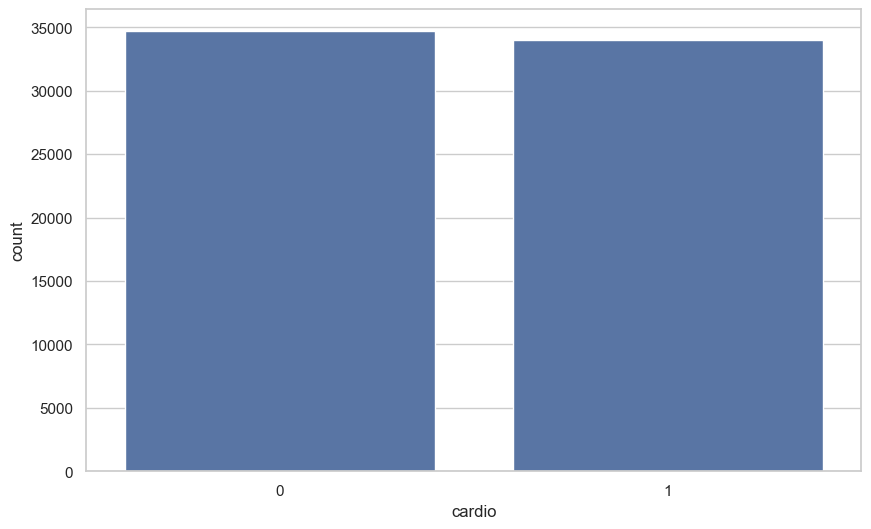

In [70]:
#Target Feature Distribution
sns.countplot(data=cleaned_cvd_data,x='cardio')

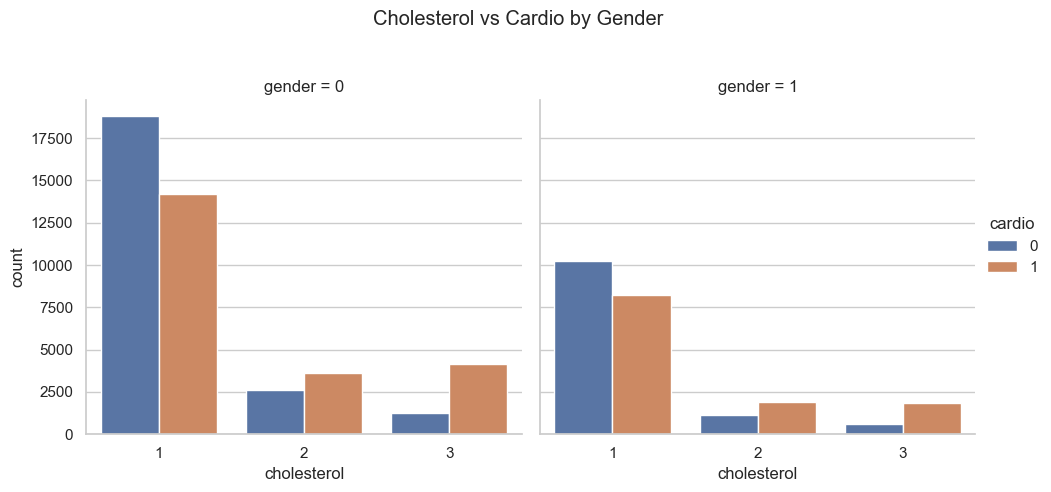

In [71]:
sns.catplot(x='cholesterol', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Cholesterol vs Cardio by Gender')
plt.show()

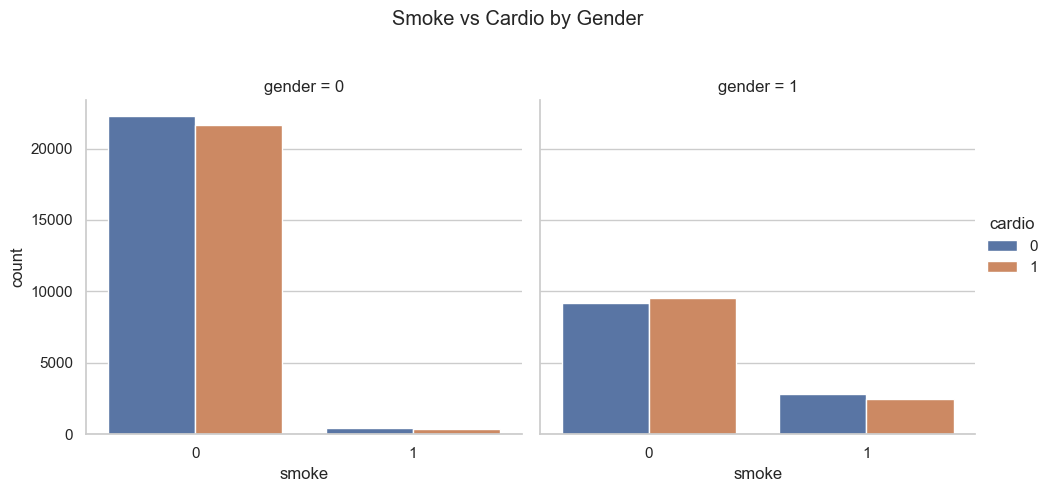

In [72]:
sns.catplot(x='smoke', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Smoke vs Cardio by Gender')
plt.show()

In [73]:
#stratify on age, gender and cardio for fairness
cleaned_cvd_data['stratify_col'] = cleaned_cvd_data['cardio'].astype(str) + '_' + cleaned_cvd_data['gender'].astype(str) + '_' + cleaned_cvd_data['age_group'].astype(str)

train_validation_data, test_data = train_test_split(
    cleaned_cvd_data,
    test_size=0.20,
    stratify=cleaned_cvd_data['stratify_col'],
    random_state=42
)

In [74]:
train_data, validation_data = train_test_split(train_validation_data, test_size=0.125, stratify=train_validation_data['stratify_col'], random_state=42)

In [75]:
#drop unnecessary columns
drop_cols = ['id', 'stratify_col', 'age_group']
train_data.drop(columns=drop_cols, inplace=True)
validation_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

In [76]:
#create train validation test X,y
X_train = train_data.drop('cardio', axis=1)
y_train = train_data['cardio']

X_validation = validation_data.drop('cardio', axis=1)
y_validation = validation_data['cardio']

X_test = test_data.drop('cardio', axis=1)
y_test = test_data['cardio']

In [ ]:
model_names = ['logistic_regression', 'svc', 'knn', 'random_forest', 'xgboost']

In [78]:
#cross validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
pre_processor = ColumnTransformer([
    ('num', StandardScaler(), cont_cols),
    ('pass', 'passthrough', [c for c in X_train.columns if c not in cont_cols])
])

gs_models = {
    'logistic_regression': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', LogisticRegression(random_state=42))
        ]),
        'param_grid': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l2'],
            'model__max_iter': [1000, 2000, 3000]
        }
    },
    'knn': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', KNeighborsClassifier())
        ]),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            'model__weights': ['uniform', 'distance',],
            'model__p': [1, 2],
            'model__algorithm': ['auto', 'kd_tree'],
            'model__leaf_size': [20, 40]
        }
    },
    'random_forest': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, None],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'xgboost': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),
        'param_grid': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'svc': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', SVC(probability=True, random_state=42))
        ]),
        'param_grid': {
            'model__kernel': ['rbf'],
            # 'model__gamma': ['scale', 'auto']
        }
    },
}

grid_search_results = {}

for name, gs in gs_models.items():
    print(f"Running grid search for: {name}")
    gs = GridSearchCV(gs['pipeline'], gs['param_grid'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best_params_clean = {k.replace('model__', ''): v for k, v in gs.best_params_.items()}
    
    grid_search_results[name] = {
        'best_params': best_params_clean,
        'best_score': gs.best_score_,
        'best_estimator': gs.best_estimator_
    }

Running grid search for: logistic_regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running grid search for: knn
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Running grid search for: random_forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Running grid search for: xgboost
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [80]:
for name, res in grid_search_results.items():
    print(f"Best parameters for {name}: {res['best_params']}")
    print(f"Best ROC-AUC for {name}: {res['best_score']:.4f}")

Best parameters for logistic_regression: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Best ROC-AUC for logistic_regression: 0.7918
Best parameters for knn: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best ROC-AUC for knn: 0.7669
Best parameters for random_forest: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
Best ROC-AUC for random_forest: 0.7962
Best parameters for xgboost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best ROC-AUC for xgboost: 0.8022


In [ ]:
#final model training
final_models = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42, **grid_search_results['logistic_regression']['best_params']))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier(**grid_search_results['knn']['best_params']))
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42, **grid_search_results['random_forest']['best_params']))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42, eval_metric='logloss', **grid_search_results['xgboost']['best_params']))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True, random_state=42, **grid_search_results['svc']['best_params']))
    ])  
}


In [82]:
for name, pipeline in final_models.items():
    print(f"Training final model: {name}")
    pipeline.fit(X_train, y_train)

Training final model: logistic_regression
Training final model: knn
Training final model: random_forest
Training final model: xgboost


In [83]:
def get_results(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)
    cm = confusion_matrix(y, y_pred)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        'confusion_matrix': cm,
        'y_proba': y_proba,
        'prob_true': prob_true,
        'prob_pred': prob_pred
    }

In [84]:
results_uncalibrated = {}

for name, model in final_models.items():    
    results_uncalibrated[name] = get_results(model, X_test, y_test)

results_uncalibrated

{'logistic_regression': {'accuracy': 0.7300327630141973,
  'f1_score': 0.709722874589009,
  'roc_auc': 0.794743596502162,
  'brier_score': 0.18557272647578396,
  'confusion_matrix': array([[5494, 1444],
         [2264, 4533]]),
  'y_proba': array([0.22208317, 0.19243621, 0.27537798, ..., 0.32553858, 0.16108404,
         0.22607569]),
  'prob_true': array([0.0795756 , 0.13697404, 0.23709168, 0.29798197, 0.45999018,
         0.58517953, 0.73752013, 0.79794791, 0.84304584, 0.86582569]),
  'prob_pred': array([0.07039701, 0.15485603, 0.25133547, 0.35023943, 0.4465743 ,
         0.54790295, 0.65112834, 0.74976251, 0.85123291, 0.94144504])},
 'knn': {'accuracy': 0.7146705496905715,
  'f1_score': 0.7054933493649959,
  'roc_auc': 0.7694863240030989,
  'brier_score': 0.19854386603567528,
  'confusion_matrix': array([[5122, 1816],
         [2103, 4694]]),
  'y_proba': array([0.11111111, 0.33333333, 0.11111111, ..., 0.33333333, 0.11111111,
         0.        ]),
  'prob_true': array([0.13767209, 0

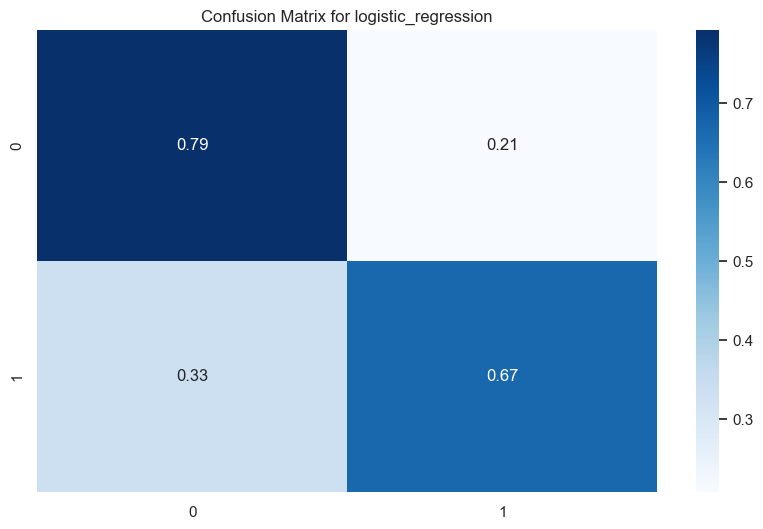

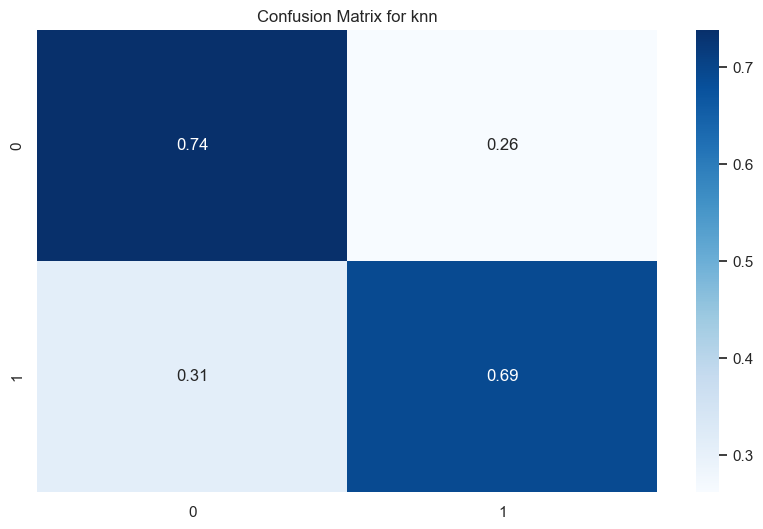

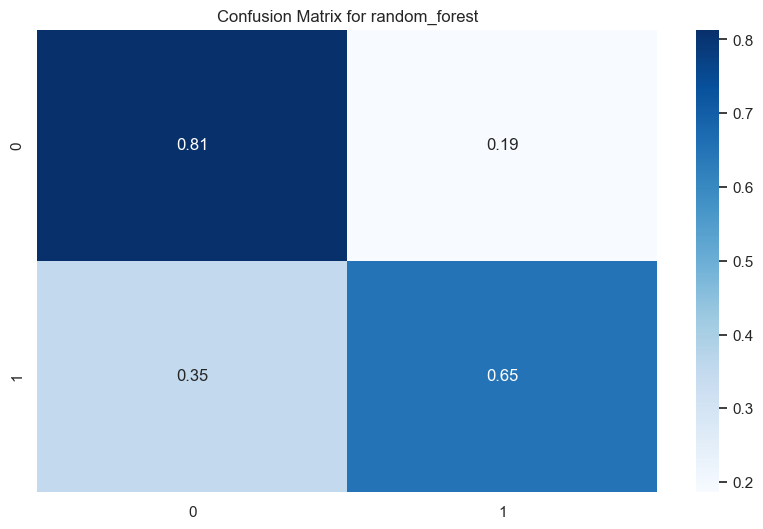

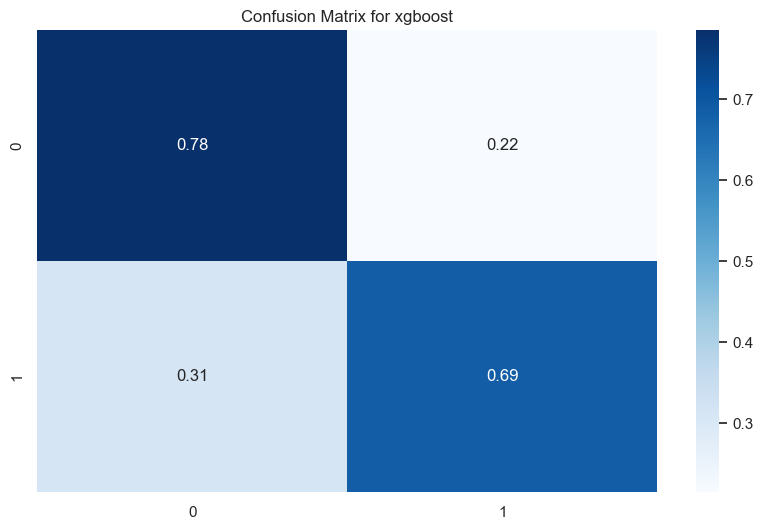

In [85]:
for name in results_uncalibrated:
    cm = results_uncalibrated[name]['confusion_matrix']
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

In [86]:
#model calibration: isotonic, platt scaling

calibrated_models_isotonic = {}
calibrated_models_platt = {}

for name, model in final_models.items():
    print(f"Calibrating model: {name} with isotonic regression")
    iso_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic')
    iso_calibrator.fit(X_validation, y_validation)
    calibrated_models_isotonic[name] = iso_calibrator
    
    print(f"Calibrating model: {name} with Platt scaling")
    platt_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='sigmoid')
    platt_calibrator.fit(X_validation, y_validation)
    calibrated_models_platt[name] = platt_calibrator

Calibrating model: logistic_regression with isotonic regression
Calibrating model: logistic_regression with Platt scaling
Calibrating model: knn with isotonic regression
Calibrating model: knn with Platt scaling
Calibrating model: random_forest with isotonic regression
Calibrating model: random_forest with Platt scaling
Calibrating model: xgboost with isotonic regression
Calibrating model: xgboost with Platt scaling


In [87]:
results_calibrated_isotonic = {}
results_calibrated_platt = {}

for name, model in calibrated_models_isotonic.items():
    results_calibrated_isotonic[name] = get_results(model, X_test, y_test)

for name, model in calibrated_models_platt.items():    
    results_calibrated_platt[name] = get_results(model, X_test, y_test)

In [88]:
def display_calibration_curve(name, label, prob_true, prob_pred):
    plt.figure(figsize=(5, 5))
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.title(f"Calibration Curve — {name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.grid()
    plt.show()

'Calibration Curves for logistic_regression:'

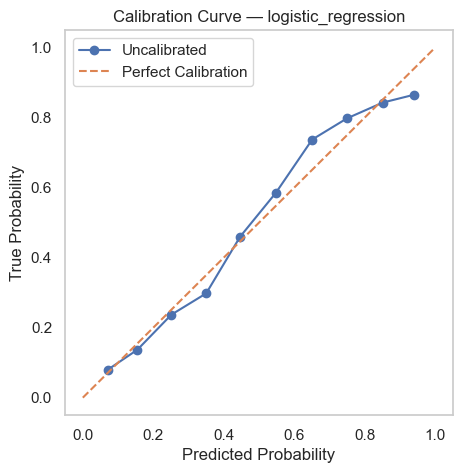

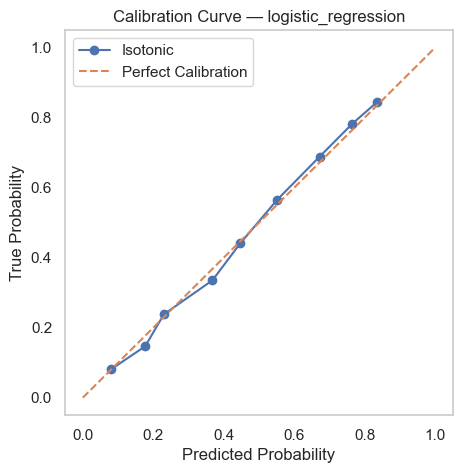

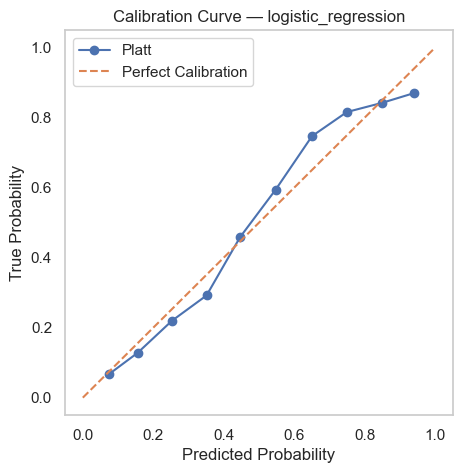

'Calibration Curves for random_forest:'

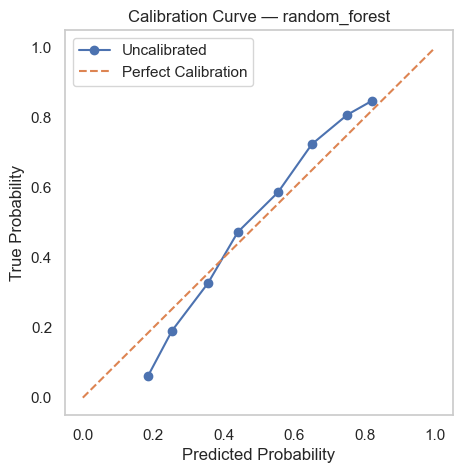

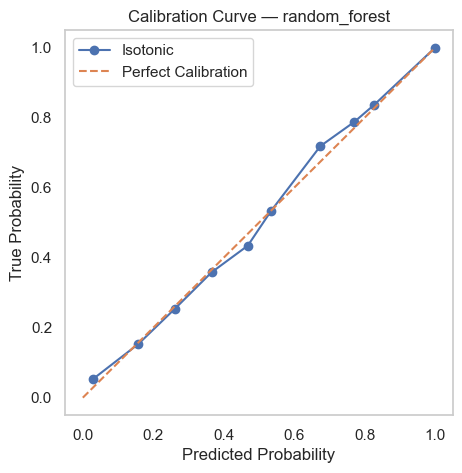

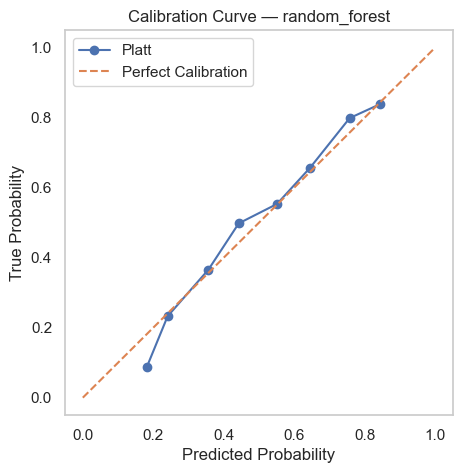

'Calibration Curves for xgboost:'

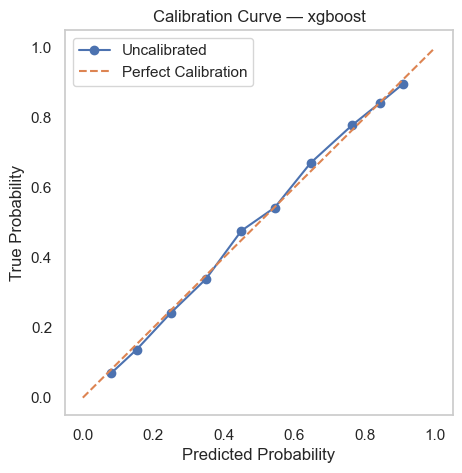

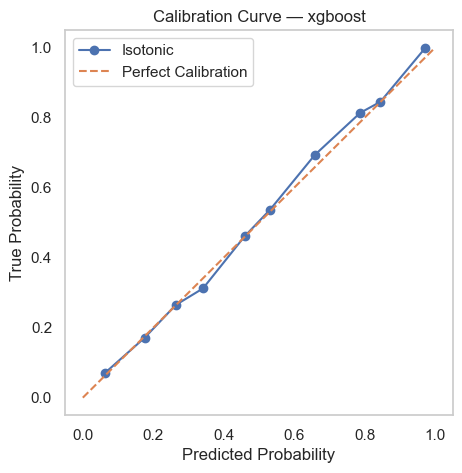

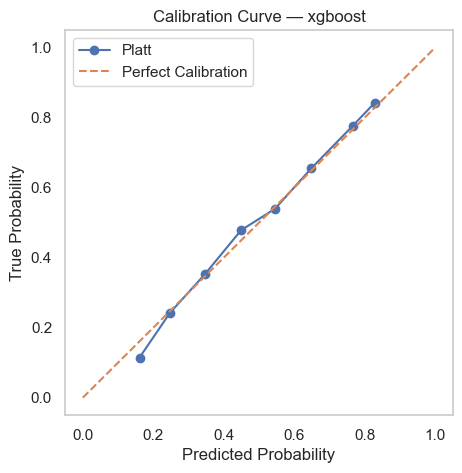

In [90]:
for name in model_names:
    display(f'Calibration Curves for {name}:')
    display_calibration_curve(name, 'Uncalibrated', results_uncalibrated[name]['prob_true'], results_uncalibrated[name]['prob_pred'])
    display_calibration_curve(name, 'Isotonic', results_calibrated_isotonic[name]['prob_true'], results_calibrated_isotonic[name]['prob_pred'])
    display_calibration_curve(name, 'Platt', results_calibrated_platt[name]['prob_true'], results_calibrated_platt[name]['prob_pred'])

In [93]:
comparison_rows = []

for name in model_names:
    comparison_rows.append({"model": name, "calibration": 'Uncalibrated', **results_uncalibrated[name]})
    comparison_rows.append({"model": name, "calibration": 'Isotonic', **results_calibrated_isotonic[name]})
    comparison_rows.append({"model": name, "calibration": 'Platt', **results_calibrated_platt[name]})
    
    comparison_df = pd.DataFrame(comparison_rows)
    
comparison_df = comparison_df[
    ["model", "calibration", "accuracy", "f1_score", "roc_auc", "brier_score"]
]

display(comparison_df)

,model,calibration,accuracy,f1_score,roc_auc,brier_score
0,logistic_regression,Uncalibrated,0.730033,0.709723,0.794744,0.185573
1,logistic_regression,Isotonic,0.731707,0.724651,0.793541,0.184351
2,logistic_regression,Platt,0.729232,0.707741,0.794744,0.186342
3,random_forest,Uncalibrated,0.732217,0.705995,0.797560,0.184579
4,random_forest,Isotonic,0.730615,0.731534,0.796695,0.182367
5,random_forest,Platt,0.730834,0.705957,0.797560,0.182981
6,xgboost,Uncalibrated,0.735857,0.719846,0.804406,0.179015
7,xgboost,Isotonic,0.735493,0.718786,0.803373,0.179719
8,xgboost,Platt,0.736294,0.721256,0.804406,0.179256
